In [ ]:
!pip install rdkit
!pip install selfies
!pip install deepchem
!pip install gensim
!pip install torch

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem import PandasTools
from rdkit.Chem.rdmolops import RemoveHs
from rdkit.Chem import rdmolfiles
from rdkit.Chem import rdMolDescriptors
from rdkit import DataStructs

import selfies as sf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# For handling the embedding layer and Mol2Vec
from gensim.models import word2vec
from gensim.models import Word2Vec
import deepchem as dc

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


NameError: name 'deepchem' is not defined

In [ ]:
import requests
import pandas as pd

# Step 1: Download the TSV file
url = "https://www.bindingdb.org/rwd/tmp/rohk_stanford.edu8884.tsv"
output_tsv = "rohk_stanford.tsv"
output_csv = "rohk_stanford.csv"

# Download the file
response = requests.get(url)
if response.status_code == 200:
    with open(output_tsv, 'wb') as file:
        file.write(response.content)
    print(f"TSV file saved as {output_tsv}")
else:
    print("Failed to download the file.")

# Step 2: Convert TSV to CSV using pandas
try:
    data = pd.read_csv(output_tsv, sep='\t')  # Read the TSV file
    data.to_csv(output_csv, index=False)  # Save as CSV
    print(f"Converted CSV file saved as {output_csv}")
except Exception as e:
    print(f"An error occurred: {e}")

TSV file saved as rohk_stanford.tsv
Converted CSV file saved as rohk_stanford.csv


In [ ]:
df = pd.read_csv('rohk_stanford.csv')
df.head()


,BindingDB Reactant_set_id,Ligand SMILES,Ligand InChI,Ligand InChI Key,BindingDB MonomerID,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),...,UniProt (SwissProt) Recommended Name of Target Chain,UniProt (SwissProt) Entry Name of Target Chain,UniProt (SwissProt) Primary ID of Target Chain,UniProt (SwissProt) Secondary ID(s) of Target Chain,UniProt (SwissProt) Alternative ID(s) of Target Chain,UniProt (TrEMBL) Submitted Name of Target Chain,UniProt (TrEMBL) Entry Name of Target Chain,UniProt (TrEMBL) Primary ID of Target Chain,UniProt (TrEMBL) Secondary ID(s) of Target Chain,UniProt (TrEMBL) Alternative ID(s) of Target Chain
0,1201594,Cc1cncc2ccc(NC(=O)[C@@H]3CC3c3ccc(cc3)S(=O)(=O...,InChI=1S/C24H21N5O3S/c1-15-12-26-13-17-2-5-18(...,MQYWUAVOLVOSFD-FOIFJWKZSA-N,569235,"US11427563, Compound 10::US11427563, Compound ...",Tyrosine-protein kinase JAK2,Homo sapiens,NaN,0.000,...,Tyrosine-protein kinase JAK2,JAK2_HUMAN,O60674,O14636 O75297,NaN,NaN,NaN,NaN,NaN,NaN
1,1201636,Cc1cncc2ccc(NC(=O)[C@@H]3CC3c3ccc(cc3)S(=O)(=O...,InChI=1S/C24H21N5O3S/c1-15-12-26-13-17-2-5-18(...,MQYWUAVOLVOSFD-FOIFJWKZSA-N,569235,"US11427563, Compound 10::US11427563, Compound ...",Tyrosine-protein kinase JAK2,Homo sapiens,NaN,0.000,...,Tyrosine-protein kinase JAK2,JAK2_HUMAN,O60674,O14636 O75297,NaN,NaN,NaN,NaN,NaN,NaN
2,1201680,FC(F)(F)Oc1cncc2ccc(NC(=O)[C@@H]3CC3c3ccc(cc3)...,"InChI=1S/C25H19F3N4O4S/c26-25(27,28)36-22-14-2...",PLUJEADAMOIDHN-VGAJERRHSA-N,569313,"US11427563, Compound 69",Tyrosine-protein kinase JAK2,Homo sapiens,NaN,0.000,...,Tyrosine-protein kinase JAK2,JAK2_HUMAN,O60674,O14636 O75297,NaN,NaN,NaN,NaN,NaN,NaN
3,1201679,FC(F)(F)Cc1cncc2ccc(NC(=O)[C@@H]3CC3c3ccc(cc3)...,"InChI=1S/C25H20F3N5O3S/c26-25(27,28)12-17-14-2...",HYWKTDGSRPVHPB-FOIFJWKZSA-N,569312,"US11427563, Compound 68",Tyrosine-protein kinase JAK2,Homo sapiens,NaN,0.000,...,Tyrosine-protein kinase JAK2,JAK2_HUMAN,O60674,O14636 O75297,NaN,NaN,NaN,NaN,NaN,NaN
4,1201663,NCc1ccnc(NS(=O)(=O)c2ccc(cc2)C2CC2C(=O)Nc2ccc3...,InChI=1S/C25H22ClN5O3S/c26-23-14-28-13-17-1-4-...,XJVGQDMDOVIHME-UHFFFAOYSA-N,569296,"US11427563, Compound 51",Tyrosine-protein kinase JAK2,Homo sapiens,NaN,0.000,...,Tyrosine-protein kinase JAK2,JAK2_HUMAN,O60674,O14636 O75297,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print("Columns in the DataFrame:")
print(df.columns.tolist())

Columns in the DataFrame:
['BindingDB Reactant_set_id', 'Ligand SMILES', 'Ligand InChI', 'Ligand InChI Key', 'BindingDB MonomerID', 'BindingDB Ligand Name', 'Target Name', 'Target Source Organism According to Curator or DataSource', 'Ki (nM)', 'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)', 'kon (M-1-s-1)', 'koff (s-1)', 'pH', 'Temp (C)', 'Curation/DataSource', 'Article DOI', 'BindingDB Entry DOI', 'PMID', 'PubChem AID', 'Patent Number', 'Authors', 'Institution', 'Link to Ligand in BindingDB', 'Link to Target in BindingDB', 'Link to Ligand-Target Pair in BindingDB', 'Ligand HET ID in PDB', 'PDB ID(s) for Ligand-Target Complex', 'PubChem CID of Ligand', 'PubChem SID of Ligand', 'ChEBI ID of Ligand', 'ChEMBL ID of Ligand', 'DrugBank ID of Ligand', 'IUPHAR_GRAC ID of Ligand', 'KEGG ID of Ligand', 'ZINC ID of Ligand', 'Number of Protein Chains in Target (>1 implies a multichain complex)', 'BindingDB Target Chain Sequence', 'PDB ID(s) of Target Chain', 'UniProt (SwissProt) Recommended Name of Target C

In [ ]:
# Convert IC50 to pIC50
def ic50_to_pic50(ic50):
    # IC50 is in nM, convert to M by multiplying by 1e-9
    return -np.log10(ic50 * 1e-9)
df['IC50 (nM)'] = pd.to_numeric(df['IC50 (nM)'], errors='coerce')
df['pIC50 (nM)'] = df['IC50 (nM)'].apply(ic50_to_pic50)

In [ ]:
df.head()

,BindingDB Reactant_set_id,Ligand SMILES,Ligand InChI,Ligand InChI Key,BindingDB MonomerID,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),...,UniProt (SwissProt) Entry Name of Target Chain,UniProt (SwissProt) Primary ID of Target Chain,UniProt (SwissProt) Secondary ID(s) of Target Chain,UniProt (SwissProt) Alternative ID(s) of Target Chain,UniProt (TrEMBL) Submitted Name of Target Chain,UniProt (TrEMBL) Entry Name of Target Chain,UniProt (TrEMBL) Primary ID of Target Chain,UniProt (TrEMBL) Secondary ID(s) of Target Chain,UniProt (TrEMBL) Alternative ID(s) of Target Chain,pIC50 (nM)
0,1201594,Cc1cncc2ccc(NC(=O)[C@@H]3CC3c3ccc(cc3)S(=O)(=O...,InChI=1S/C24H21N5O3S/c1-15-12-26-13-17-2-5-18(...,MQYWUAVOLVOSFD-FOIFJWKZSA-N,569235,"US11427563, Compound 10::US11427563, Compound ...",Tyrosine-protein kinase JAK2,Homo sapiens,NaN,0.0,...,JAK2_HUMAN,O60674,O14636 O75297,NaN,NaN,NaN,NaN,NaN,NaN,inf
1,1201636,Cc1cncc2ccc(NC(=O)[C@@H]3CC3c3ccc(cc3)S(=O)(=O...,InChI=1S/C24H21N5O3S/c1-15-12-26-13-17-2-5-18(...,MQYWUAVOLVOSFD-FOIFJWKZSA-N,569235,"US11427563, Compound 10::US11427563, Compound ...",Tyrosine-protein kinase JAK2,Homo sapiens,NaN,0.0,...,JAK2_HUMAN,O60674,O14636 O75297,NaN,NaN,NaN,NaN,NaN,NaN,inf
2,1201680,FC(F)(F)Oc1cncc2ccc(NC(=O)[C@@H]3CC3c3ccc(cc3)...,"InChI=1S/C25H19F3N4O4S/c26-25(27,28)36-22-14-2...",PLUJEADAMOIDHN-VGAJERRHSA-N,569313,"US11427563, Compound 69",Tyrosine-protein kinase JAK2,Homo sapiens,NaN,0.0,...,JAK2_HUMAN,O60674,O14636 O75297,NaN,NaN,NaN,NaN,NaN,NaN,inf
3,1201679,FC(F)(F)Cc1cncc2ccc(NC(=O)[C@@H]3CC3c3ccc(cc3)...,"InChI=1S/C25H20F3N5O3S/c26-25(27,28)12-17-14-2...",HYWKTDGSRPVHPB-FOIFJWKZSA-N,569312,"US11427563, Compound 68",Tyrosine-protein kinase JAK2,Homo sapiens,NaN,0.0,...,JAK2_HUMAN,O60674,O14636 O75297,NaN,NaN,NaN,NaN,NaN,NaN,inf
4,1201663,NCc1ccnc(NS(=O)(=O)c2ccc(cc2)C2CC2C(=O)Nc2ccc3...,InChI=1S/C25H22ClN5O3S/c26-23-14-28-13-17-1-4-...,XJVGQDMDOVIHME-UHFFFAOYSA-N,569296,"US11427563, Compound 51",Tyrosine-protein kinase JAK2,Homo sapiens,NaN,0.0,...,JAK2_HUMAN,O60674,O14636 O75297,NaN,NaN,NaN,NaN,NaN,NaN,inf


In [ ]:
df2 = pd.DataFrame({'SMILES': df['Ligand SMILES'], 'pIC50': df['pIC50 (nM)']})
df2.head()

,SMILES,pIC50
0,Cc1cncc2ccc(NC(=O)[C@@H]3CC3c3ccc(cc3)S(=O)(=O...,inf
1,Cc1cncc2ccc(NC(=O)[C@@H]3CC3c3ccc(cc3)S(=O)(=O...,inf
2,FC(F)(F)Oc1cncc2ccc(NC(=O)[C@@H]3CC3c3ccc(cc3)...,inf
3,FC(F)(F)Cc1cncc2ccc(NC(=O)[C@@H]3CC3c3ccc(cc3)...,inf
4,NCc1ccnc(NS(=O)(=O)c2ccc(cc2)C2CC2C(=O)Nc2ccc3...,inf


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:

PandasTools.AddMoleculeColumnToFrame(df2,'SMILES','Molecule')
df2[["SMILES","Molecule"]].head(1)

[13:14:20] Explicit valence for atom # 21 N, 4, is greater than permitted
[13:14:20] Explicit valence for atom # 23 N, 4, is greater than permitted
[13:14:21] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[13:14:21] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[13:14:21] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[13:14:22] Explicit valence for atom # 21 N, 4, is greater than permitted
[13:14:22] Can't kekulize mol.  Unkekulized atoms: 19 20 30
[13:14:22] Explicit valence for atom # 1 N, 4, is greater than permitted
[13:14:23] Can't kekulize mol.  Unkekulized atoms: 8 9 10 14 15
[13:14:23] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[13:14:23] Explicit valence for atom # 23 N, 4, is greater than permitted
[13:14:24] Explicit valence for atom # 41 N, 4, is greater than permitted
[13:14:24] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[13:14:24] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[13:14:24] Can't kekulize mol.  Unkekulized at

,SMILES,Molecule
0,Cc1cncc2ccc(NC(=O)[C@@H]3CC3c3ccc(cc3)S(=O)(=O...,<rdkit.Chem.rdchem.Mol object at 0x7d2cd4ca0eb0>


In [ ]:
!python -m pip install git+https://github.com/EBjerrum/molvecgen
from molvecgen.vectorizers import SmilesVectorizer

  Cloning https://github.com/EBjerrum/molvecgen to /tmp/pip-req-build-w7d7n6w8
  Running command git clone --filter=blob:none --quiet https://github.com/EBjerrum/molvecgen /tmp/pip-req-build-w7d7n6w8
  Resolved https://github.com/EBjerrum/molvecgen to commit f81d5aade18bea60882f5845877f6283366bbe91
  Preparing metadata (setup.py) ... done


In [ ]:
df2 = df2[df2['SMILES'].notna()] # removing missing values
df2 = df2[df2['Molecule'].notna()] # Remove rows with invalid molecules
df2 = df2[df2['Molecule'] != '' ]
df2 = df2[df2['SMILES'] != '' ]
df2 = df2.reset_index(drop=True)
df2['Molecule'] = df2['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))

# Filter out rows with None in the 'Molecule' column
df2 = df2[df2['Molecule'].notnull()].copy()

# Now try fitting the SmilesVectorizer
smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)
smivec.fit(df2.Molecule.values)

In [ ]:
print(smivec.charset)
smivec.dims

Fn/)B4l#=6iO2+3PNH17[SoI].c@s5(rC-\8^$?


(155, 39)

In [ ]:
df2 = df2[np.isfinite(df2['pIC50'])]

y = df2.pIC50.values.reshape((-1,1))
X = df2.Molecule.values
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.10, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.05, random_state=42)
#Normalizing output using standard scaling
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

In [ ]:
class SMILESMolDataset(Dataset):
    def __init__(self, molecules, y, vectorizer):
        self.molecules = molecules
        self.y = y
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.molecules)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        mols = self.molecules[idx]

        #The vectorizer was written to work with batches,
        #but PyTorch datasets unfortunately works with single samples
        sample = self.vectorizer.transform([mols])[0]
        label = self.y[idx]
        return sample, label

In [ ]:
train_dataset = SMILESMolDataset(X_train, y_train, smivec)
train_dataset[0]

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0]], dtype=int8),
 array([-0.05191751]))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
X_validation_t = smivec.transform(X_validation, canonical=False)
X_validation_t = torch.tensor(X_validation_t, device=device).float()
y_validation_t = torch.tensor(y_validation, device=device).float()
X_validation_t.shape

cuda:0


torch.Size([609, 155, 39])

In [ ]:
X_validation_t[0]

In [ ]:
class Net(nn.Module):
    def __init__(self, dimensions, lstm_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()

        length = dims[0]
        number_tokens = dims[1]


        self.lstm = nn.LSTM(input_size=number_tokens, hidden_size=lstm_size, num_layers=1, batch_first=True, bidirectional=False)
        self.fc1 = nn.Linear(lstm_size, hidden_size) # Output layer
        self.activation = nn.ReLU() # Non-Linear ReLU Layer
        self.fc_out = nn.Linear(hidden_size, out_size) # Output layer
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):# Forward pass: stacking each layer together
        out, (h_n, c_n) = self.lstm(x) #LSTM network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        out = self.dropout(h_n) #Dropout
        out = self.fc1(out) # Pass into the hidden layer
        out = self.activation(out) # Use ReLU on hidden activation
        out = self.dropout(out) # dropout
        out = self.fc_out(out) # Use a linear layer for the output
        return out

In [ ]:
epochs = 750
dims = smivec.dims
lstm_size = 128  # The size of the LSTM layer
hidden_size = 128  # The size of the hidden non-linear layer
dropout_rate = 0.50 # The dropout rate
output_size = 1        # This is just a single task, so this will be one
batch_size = 128   # The mini_batch size during training
learning_rate = 0.003  # The initial learning rate for the optimizer

In [ ]:
model = Net(smivec, lstm_size, hidden_size, dropout_rate, output_size)
model.cuda()

Net(
  (lstm): LSTM(39, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (activation): ReLU()
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
pred = model.forward(X_validation_t[10:11])
pred

tensor([[[0.0194]]], device='cuda:0', grad_fn=<ViewBackward0>)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50,
                  verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08)


In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=4)

In [ ]:
for smiles, labels in train_loader:
    break

In [ ]:
model.train() #Ensure the network is in "train" mode with dropouts active
train_losses = []
validation_losses = []
for e in range(epochs):
    running_loss = 0
    for smiles, labels in train_loader:
        # Push numpy to CUDA tensors
        smiles = torch.tensor(smiles, device=device).float()
        labels = torch.tensor(labels, device=device).float()
        # Training pass
        optimizer.zero_grad() # Initialize the gradients, which will be recorded during the forward pass

        output = model(smiles) #Forward pass of the mini-batch
        loss = criterion(output, labels) #Computing the loss
        loss.backward() # calculate the backward pass
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step() # Optimize the weights

        running_loss += loss.item()
    else:


        model.eval()
        validation_loss = torch.mean(( y_validation_t - model(X_validation_t) )**2).item()
        model.train()

        lr_scheduler.step(validation_loss)

        train_loss = running_loss/len(train_loader)
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        if (e+1)%10 == 0:
            print("Epoch %i, Training loss: %0.2F Validation loss: %0.2F"%(e + 1, train_loss, validation_loss))

Epoch 10, Training loss: 1.00 Validation loss: 0.86
Epoch 20, Training loss: 0.81 Validation loss: 0.70
Epoch 30, Training loss: 0.70 Validation loss: 0.61
Epoch 40, Training loss: 0.59 Validation loss: 0.49
Epoch 50, Training loss: 0.53 Validation loss: 0.47
Epoch 60, Training loss: 0.50 Validation loss: 0.43
Epoch 70, Training loss: 0.47 Validation loss: 0.40
Epoch 80, Training loss: 0.45 Validation loss: 0.39
Epoch 90, Training loss: 0.43 Validation loss: 0.38
Epoch 100, Training loss: 0.43 Validation loss: 0.37
Epoch 110, Training loss: 0.40 Validation loss: 0.36
Epoch 120, Training loss: 0.40 Validation loss: 0.35
Epoch 130, Training loss: 0.38 Validation loss: 0.35
Epoch 140, Training loss: 0.38 Validation loss: 0.35
Epoch 150, Training loss: 0.38 Validation loss: 0.35
Epoch 160, Training loss: 0.37 Validation loss: 0.34
Epoch 170, Training loss: 0.36 Validation loss: 0.35
Epoch 180, Training loss: 0.36 Validation loss: 0.35
Epoch 190, Training loss: 0.35 Validation loss: 0.36
Ep

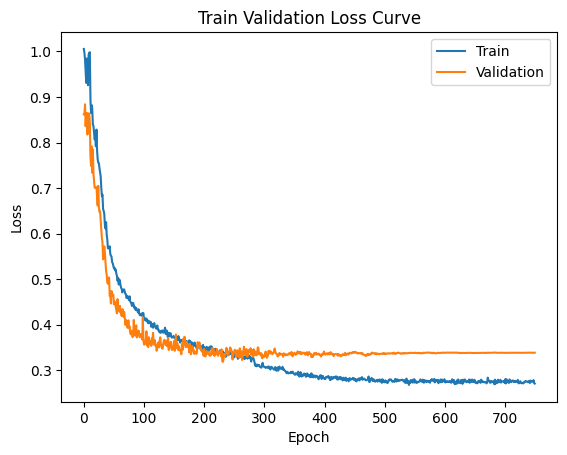

In [ ]:
plt.title("Train Validation Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(train_losses, label="Train")
plt.plot(validation_losses, label="Validation")
#plt.yscale('log')
plt.legend()

In [ ]:
model.load_state_dict(torch.load("model.pth"))
model.eval()  # Set the model to evaluation mode

print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
model.eval() #Swith to evaluation mode, where dropout is switched off
#y_pred_train = model(X_train_t)
y_pred_validation = model(X_validation_t)
#y_pred_test = model(X_test)

In [ ]:
torch.mean(( y_validation_t - y_pred_validation )**2).item()

0.33847567439079285

In [ ]:
X_train_t = smivec.transform(X_train, canonical=False)
X_train_t = torch.tensor(X_train_t, device=device).float()
y_train_t = torch.tensor(y_train, device=device).float()
X_test_t = smivec.transform(X_test, canonical=False)
X_test_t = torch.tensor(X_test_t, device=device).float()
y_test_t = torch.tensor(y_test, device=device).float()

In [ ]:
X_train_t

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [ ]:
y_pred_train = model(X_train_t)
y_pred_test = model(X_test_t)
train_rmse = torch.mean(( y_train_t - y_pred_train )**2).item()
test_rmse = torch.mean(( y_test_t - y_pred_test )**2).item()
print("Train RMSE: %0.3F\tTest RMSE: %0.3F"%(train_rmse, test_rmse))

Train RMSE: 0.255	Test RMSE: 0.373


In [ ]:
torch.save(X_train_t, "X_train_t.pt")
torch.save(y_train_t, "y_train_t.pt")
torch.save(X_test_t, "X_test_t.pt")
torch.save(y_test_t, "y_test_t.pt")

print("Tensors saved in Colab environment!")

Tensors saved in Colab environment!


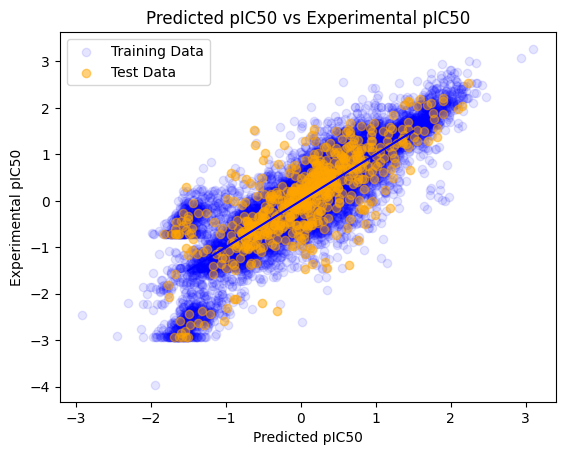

In [ ]:
plt.xlabel("Predicted pIC50")
plt.ylabel("Experimental pIC50")
plt.title("Predicted pIC50 vs Experimental pIC50")

plt.scatter(np.array(y_pred_train.tolist()).flatten(), np.array(y_train_t.tolist()).flatten(), alpha=0.1, label="Training Data",
    color='blue')
plt.scatter(np.array(y_pred_validation.tolist()).flatten(), np.array(y_validation_t.tolist()).flatten(), alpha=0.5, label="Test Data",
    color='orange')

plt.legend()

plt.plot([-1.5, 1.5], [-1.5,1.5], c="b")

In [ ]:
torch.save(model.state_dict(), "finalmodel.pth")

print("Model state dictionary saved!")

Model state dictionary saved!


In [ ]:
torch.save(model, "finalmodel_full.pth")

print("Entire model saved!")

Entire model saved!


In [ ]:
torch.save(X_train_t, "X_train_t.pt")
torch.save(y_train_t, "y_train_t.pt")
torch.save(X_test_t, "X_test_t.pt")
torch.save(y_test_t, "y_test_t.pt")

print("Tensors saved in Colab environment!")

In [ ]:
import torch
model = torch.load("model_full.pth")
model.eval()

print("Entire model loaded successfully!")

Entire model loaded successfully!


In [ ]:
# Remove duplicates and average pIC50 values for duplicate SMILES
df2 = df2.groupby('SMILES').agg({'pIC50': 'mean'}).reset_index()

# Add a molecule column from SMILES
df2['Molecule'] = df2['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))

# Filter out molecules that could not be parsed
df2 = df2[df2['Molecule'].notnull()]


[10:56:27] Explicit valence for atom # 21 N, 4, is greater than permitted
[10:56:28] Can't kekulize mol.  Unkekulized atoms: 19 20 30
[10:56:28] Explicit valence for atom # 30 N, 4, is greater than permitted
[10:56:29] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[10:56:29] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[10:56:29] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[10:56:29] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
[10:56:29] Can't kekulize mol.  Unkekulized atoms: 10 12 13
[10:56:29] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[10:56:29] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[10:56:29] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[10:56:29] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12
[10:56:29] Explicit valence for atom # 21 N, 4, is greater than permitted
[10:56:29] Can't kekulize mol.  Unkekulized atoms: 8 9 10 14 15
[10:56:29] Can't kekulize mol.  Unkekulized atoms: 8 9 10 14 15
[10:56:29] Can

In [ ]:
df_training = df2[df2['pIC50'].notna()]

In [ ]:

df_training.head()

,SMILES,pIC50,Molecule
1,BrC[C@H]1CC[C@@H](CC1)c1nnn2cnc3[nH]ccc3c12,8.068969,<rdkit.Chem.rdchem.Mol object at 0x7bbce29ae490>
2,Brc1cc(CN2CCC(CC2)c2nnn3cnc4[nH]ccc4c23)sc1Br,7.148742,<rdkit.Chem.rdchem.Mol object at 0x7bbce29ae340>
3,Brc1ccc(CN2CCC(CC2)c2nnn3cnc4[nH]ccc4c23)cc1,7.655647,<rdkit.Chem.rdchem.Mol object at 0x7bbce29adf50>
4,Brc1ccc(CN2CCC(CC2)c2nnn3cnc4[nH]ccc4c23)o1,8.552842,<rdkit.Chem.rdchem.Mol object at 0x7bbce29ae030>
5,Brc1ccc(CN2CCC(CC2)c2nnn3cnc4[nH]ccc4c23)s1,8.337242,<rdkit.Chem.rdchem.Mol object at 0x7bbce29ae110>


In [ ]:
!pip install selfies

In [ ]:
import selfies as sf


In [ ]:

# Calculate RDKit descriptors
def calculate_descriptors(mol):
    descriptor_names = [desc[0] for desc in Descriptors._descList]
    descriptor_values = [desc[1](mol) for desc in Descriptors._descList]
    return pd.Series(descriptor_values, index=descriptor_names)

descriptor_df = df_training['Molecule'].apply(calculate_descriptors)
descriptor_df = descriptor_df.fillna(0)  # Replace NaN with zeros

# Normalize descriptors
scaler = StandardScaler()
descriptor_df_scaled = pd.DataFrame(scaler.fit_transform(descriptor_df), columns=descriptor_df.columns)

# Choose sequence representation: SELFIES
def molecule_to_selfies(mol):
    smiles = Chem.MolToSmiles(mol)
    return sf.encoder(smiles)

df_training['SELFIES'] = df_training['Molecule'].apply(molecule_to_selfies)

# Tokenize SELFIES
def tokenize_selfies(selfies_string):
    tokens = list(sf.split_selfies(selfies_string))
    return tokens

df_training['SELFIES_tokens'] = df_training['SELFIES'].apply(tokenize_selfies)



In [ ]:
df_training.head()

,SMILES,pIC50,Molecule,SELFIES,SELFIES_tokens
1,BrC[C@H]1CC[C@@H](CC1)c1nnn2cnc3[nH]ccc3c12,8.068969,<rdkit.Chem.rdchem.Mol object at 0x7bbce29ae490>,[Br][C][C@H1][C][C][C@H1][Branch2][Ring1][Ring...,"[[Br], [C], [C@H1], [C], [C], [C@H1], [Branch2..."
2,Brc1cc(CN2CCC(CC2)c2nnn3cnc4[nH]ccc4c23)sc1Br,7.148742,<rdkit.Chem.rdchem.Mol object at 0x7bbce29ae340>,[Br][C][C][=C][Branch2][Ring1][S][C][N][C][C][...,"[[Br], [C], [C], [=C], [Branch2], [Ring1], [S]..."
3,Brc1ccc(CN2CCC(CC2)c2nnn3cnc4[nH]ccc4c23)cc1,7.655647,<rdkit.Chem.rdchem.Mol object at 0x7bbce29adf50>,[Br][C][=C][C][=C][Branch2][Ring1][S][C][N][C]...,"[[Br], [C], [=C], [C], [=C], [Branch2], [Ring1..."
4,Brc1ccc(CN2CCC(CC2)c2nnn3cnc4[nH]ccc4c23)o1,8.552842,<rdkit.Chem.rdchem.Mol object at 0x7bbce29ae030>,[Br][C][=C][C][=C][Branch2][Ring1][S][C][N][C]...,"[[Br], [C], [=C], [C], [=C], [Branch2], [Ring1..."
5,Brc1ccc(CN2CCC(CC2)c2nnn3cnc4[nH]ccc4c23)s1,8.337242,<rdkit.Chem.rdchem.Mol object at 0x7bbce29ae110>,[Br][C][=C][C][=C][Branch2][Ring1][S][C][N][C]...,"[[Br], [C], [=C], [C], [=C], [Branch2], [Ring1..."


In [ ]:
# Build vocabulary for SELFIES tokens
all_tokens = [token for tokens in df_training['SELFIES_tokens'] for token in tokens]
unique_tokens = list(set(all_tokens))
token_to_idx = {token: idx+1 for idx, token in enumerate(unique_tokens)}  # Start indexing from 1
token_to_idx['<PAD>'] = 0  # Add padding token
idx_to_token = {idx: token for token, idx in token_to_idx.items()}

# Convert tokens to indices
max_seq_length = max(df_training['SELFIES_tokens'].apply(len))

def selfies_to_indices(tokens, max_seq_length, token_to_idx):
    indices = [token_to_idx[token] for token in tokens]
    # Pad sequences
    if len(indices) < max_seq_length:
        indices += [token_to_idx['<PAD>']] * (max_seq_length - len(indices))
    else:
        indices = indices[:max_seq_length]
    return indices

df_training['SELFIES_indices'] = df_training['SELFIES_tokens'].apply(lambda x: selfies_to_indices(x, max_seq_length, token_to_idx))

# Prepare final dataset
X_sequence = np.array(df_training['SELFIES_indices'].tolist())
X_descriptors = descriptor_df_scaled.values
y = df_training['pIC50'].values

# Split data into training and evaluation sets
X_seq_train, X_seq_eval, X_desc_train, X_desc_eval, y_train, y_eval = train_test_split(
    X_sequence, X_descriptors, y, test_size=0.2, random_state=42)


In [ ]:
X_desc_train

NameError: name 'X_desc_train' is not defined

In [ ]:
# Define a custom Dataset
class QSARDataset(Dataset):
    def __init__(self, sequences, descriptors, targets):
        self.sequences = torch.tensor(sequences, dtype=torch.long)
        self.descriptors = torch.tensor(descriptors, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.sequences[idx], self.descriptors[idx], self.targets[idx]

# Create DataLoaders
batch_size = 16

train_dataset = QSARDataset(X_seq_train, X_desc_train, y_train)
eval_dataset = QSARDataset(X_seq_eval, X_desc_eval, y_eval)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)


NameError: name 'Dataset' is not defined

In [ ]:
# Define the QSAR model architecture
class QSARModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, lstm_hidden_size, descriptor_input_size, dropout=0.3):
        super(QSARModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=lstm_hidden_size, num_layers=2, batch_first=True, dropout=dropout)
        self.descriptor_dense = nn.Linear(descriptor_input_size, 256)
        self.final_dense = nn.Linear(lstm_hidden_size + 256, 1)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, sequence, descriptors):
        # Sequence input through embedding and LSTM
        embedded_seq = self.embedding(sequence)
        lstm_out, _ = self.lstm(embedded_seq)
        # Take the output of the last time step
        lstm_out = lstm_out[:, -1, :]  # Shape: (batch_size, lstm_hidden_size)
        lstm_out = self.dropout(lstm_out)

        # Descriptors input through dense layer
        descriptors_out = self.relu(self.descriptor_dense(descriptors))  # Shape: (batch_size, 256)
        descriptors_out = self.dropout(descriptors_out)

        # Concatenate outputs
        combined = torch.cat((lstm_out, descriptors_out), dim=1)  # Shape: (batch_size, lstm_hidden_size + 256)

        # Final output
        output = self.final_dense(combined)
        return output.squeeze()


In [ ]:
# Hyperparameters
vocab_size = len(token_to_idx)
embedding_dim = 128
lstm_hidden_size = 256
descriptor_input_size = X_descriptors.shape[1]
dropout_rate = 0.3
learning_rate = 0.001
num_epochs = 100

# Initialize the model, loss function, and optimizer
model = QSARModel(vocab_size=vocab_size, embedding_dim=embedding_dim, lstm_hidden_size=lstm_hidden_size,
                  descriptor_input_size=descriptor_input_size, dropout=dropout_rate)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

# Training loop
best_eval_loss = np.inf

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for sequences, descriptors, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(sequences, descriptors)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)

    # Evaluation
    model.eval()
    eval_losses = []
    with torch.no_grad():
        for sequences, descriptors, targets in eval_loader:
            outputs = model(sequences, descriptors)
            loss = criterion(outputs, targets)
            eval_losses.append(loss.item())
    avg_eval_loss = np.mean(eval_losses)

    scheduler.step(avg_eval_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Eval Loss: {avg_eval_loss:.4f}')

    # Save the best model
    if avg_eval_loss < best_eval_loss:
        best_eval_loss = avg_eval_loss
        torch.save(model.state_dict(), 'best_qsar_model.pth')
        print('Best model saved.')


Epoch [1/100], Train Loss: nan, Eval Loss: nan
Epoch [2/100], Train Loss: nan, Eval Loss: nan


In [ ]:
# Load the best model
model.load_state_dict(torch.load('best_qsar_model.pth'))

# Example prediction on evaluation set
model.eval()
with torch.no_grad():
    sequences, descriptors, targets = next(iter(eval_loader))
    outputs = model(sequences, descriptors)
    for i in range(len(outputs)):
        print(f'Predicted pIC50: {outputs[i]:.2f}, Actual pIC50: {targets[i]:.2f}')
